In [11]:
import parmed as pmd
import numpy as np
import os
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import colorConverter
import seaborn as sns

%load_ext autoreload
%autoreload 2
%load_ext blackcellmagic
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [3]:
from adjustText import adjust_text
import plotting

In [4]:
smirnoff = pmd.load_file("systems/a-bam-p/smirnoff/hg.prmtop")
smirnoff = smirnoff[":MGO"]

In [5]:
bgbg_tip3p = pmd.load_file("systems/a-bam-p/bgbg-tip3p/hg.topo")
bgbg_tip3p = bgbg_tip3p[":MGO"]

In [6]:
bg2bg2_tip3p = pmd.load_file("systems/a-bam-p/bg2bg2-tip3p/vac.topo")
bg2bg2_tip3p = bg2bg2_tip3p[":MGO"]

In [8]:
def scatter(df, x, y, xlabel, ylabel, lower_lim, upper_lim, highlight_color, name, adjust=False):
    fig, ax = plt.subplots(1, figsize=(6 * 1.2, 6))
    text = []

    for index, row in df.iterrows():
        if row[x] != row[y]:
            ax.scatter(
                row[x],
                row[y],
                s=80,
                edgecolor="k",
                lw=0.2,
                color="r",
                zorder=2,
            )
            # Not general 
            text.append(plt.text(row[x], row[y], f"{row['atom1']}-{row['atom2']}-{row['atom3']}-{row['atom4']}", color="r", size=14))


        else:
            ax.scatter(
                row[x],
                row[y],
                s=80,
                edgecolor="k",
                lw=0.2,
                color="0.5",
            )
    
    ax.plot([-500, 500], [-500, 500], ls="-", c="0.3", zorder=-1, lw="0.5")
    ax.set_ylim([lower_lim, upper_lim])
    ax.set_xlim([lower_lim, upper_lim])

    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    
    if adjust:
        adjust_text(text, expand_points=(2, 2), arrowprops=dict(arrowstyle="-", color="r"))

    fig.savefig(f"figures/{name}", bbox_inches="tight")

In [150]:
smirnoff_lj = pd.DataFrame()

for atom in smirnoff.atoms:

    smirnoff_lj = smirnoff_lj.append(
        pd.DataFrame(
            {
                "name": atom.name,
                "type": atom.type,
                "epsilon": atom.epsilon,
                "sigma": atom.sigma,
                
            },
            index=[0],
        ),
        ignore_index=True,
    )


bgbg_tip3p_lj = pd.DataFrame()
for atom in bgbg_tip3p.atoms:

    bgbg_tip3p_lj = bgbg_tip3p_lj.append(
        pd.DataFrame(
            {
                "name": atom.name,
                "type": atom.type,
                "epsilon": atom.epsilon,
                "sigma": atom.sigma,
                
            },
            index=[0],
        ),
        ignore_index=True,
    )


In [151]:
df = smirnoff_lj.merge(bgbg_tip3p_lj, on="name", suffixes=("_smirnoff", "_bgbg_tip3p"))

In [152]:
df.head()

,epsilon_smirnoff,name,sigma_smirnoff,type_smirnoff,epsilon_bgbg_tip3p,sigma_bgbg_tip3p,type_bgbg_tip3p
0,0.1094,C1,3.39967,1,0.1094,3.39967,c3
1,0.1094,C1,3.39967,1,0.1094,3.39967,c3
2,0.1094,C1,3.39967,1,0.1094,3.39967,c3
3,0.1094,C1,3.39967,1,0.1094,3.39967,c3
4,0.1094,C1,3.39967,1,0.1094,3.39967,c3


In [153]:
df.drop_duplicates(inplace=True, subset=["epsilon_smirnoff", "sigma_smirnoff", "epsilon_bgbg_tip3p", "sigma_bgbg_tip3p"])

In [154]:
df.head()

,epsilon_smirnoff,name,sigma_smirnoff,type_smirnoff,epsilon_bgbg_tip3p,sigma_bgbg_tip3p,type_bgbg_tip3p
0,0.1094,C1,3.399670,1,0.1094,3.399670,c3
36,0.0157,H1,2.293173,2,0.0157,2.293173,h2
72,0.1700,O1,3.000012,3,0.1700,3.000012,os
144,0.0157,H2,2.471353,5,0.0157,2.471353,h1
180,0.2104,O2,3.066473,6,0.2104,3.066473,oh


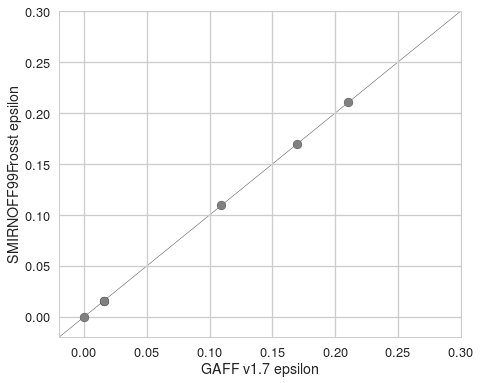

In [63]:
scatter(df, "epsilon_bgbg_tip3p", "epsilon_smirnoff", "GAFF v1.7 epsilon", "SMIRNOFF99Frosst epsilon", 
        -0.01, 0.3, "r", "SMIRNOFF99Frosst-vs-GAFF-v1.7-epsilon.pdf")

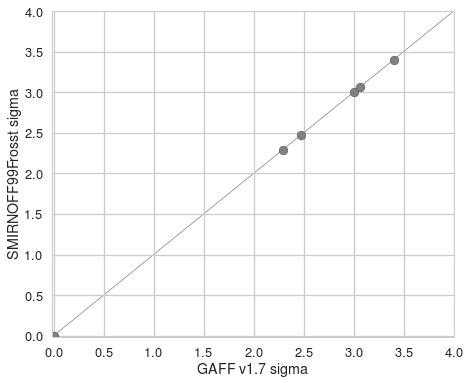

In [64]:
scatter(df, "sigma_bgbg_tip3p", "sigma_smirnoff", "GAFF v1.7 sigma", "SMIRNOFF99Frosst sigma", 4, "r", "SMIRNOFF99Frosst-vs-GAFF-v1.7-sigma.pdf")


# Bonds

In [65]:
def find_bonds(structure):
    df = pd.DataFrame()
    for atom in structure.atoms:
        for bond in atom.bonds:
            df = df.append(
                pd.DataFrame(
                    {
                        "atom1": bond.atom1.name,
                        "atom2": bond.atom2.name,
                        "atom1_type": bond.atom1.type,
                        "atom2_type": bond.atom2.type,
                        "req": bond.type.req,
                        "k": bond.type.k,
                    },
                    index=[0],
                ),
                ignore_index=True,
            )
    return df


In [67]:
smirnoff_bonds = find_bonds(smirnoff)
bgbg_tip3p_bonds = find_bonds(bgbg_tip3p)

In [70]:
df = smirnoff_bonds.merge(bgbg_tip3p_bonds, on=["atom1", "atom2"], suffixes=("_smirnoff", "_bgbg_tip3p"))

In [72]:
df.head()

,atom1,atom1_type_smirnoff,atom2,atom2_type_smirnoff,k_smirnoff,req_smirnoff,atom1_type_bgbg_tip3p,atom2_type_bgbg_tip3p,k_bgbg_tip3p,req_bgbg_tip3p
0,C1,1,O1,3,320.0,1.37,c3,os,301.5,1.439
1,C1,1,O1,3,320.0,1.37,c3,os,301.5,1.439
2,C1,1,O1,3,320.0,1.37,c3,os,301.5,1.439
3,C1,1,O1,3,320.0,1.37,c3,os,301.5,1.439
4,C1,1,O1,3,320.0,1.37,c3,os,301.5,1.439


In [85]:
df.drop_duplicates(inplace=True, subset=["k_smirnoff", "req_smirnoff", "k_bgbg_tip3p", "req_bgbg_tip3p"])

In [89]:
df[["k_smirnoff", "k_bgbg_tip3p"]].min()
df[["k_smirnoff", "k_bgbg_tip3p"]].max()

k_smirnoff      553.0
k_bgbg_tip3p    369.6
dtype: float64

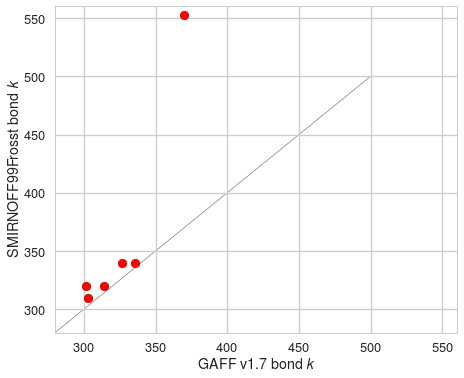

In [90]:
scatter(df, "k_bgbg_tip3p", "k_smirnoff", r"GAFF v1.7 bond $k$", r"SMIRNOFF99Frosst bond $k$", 280, 560, "r", 
        "SMIRNOFF99Frosst-vs-GAFF-v1.7-bond-k.pdf")


In [91]:
df[["req_smirnoff", "req_bgbg_tip3p"]].min()

req_smirnoff      0.960
req_bgbg_tip3p    0.974
dtype: float64

In [92]:
df[["req_smirnoff", "req_bgbg_tip3p"]].max()

req_smirnoff      1.526
req_bgbg_tip3p    1.535
dtype: float64

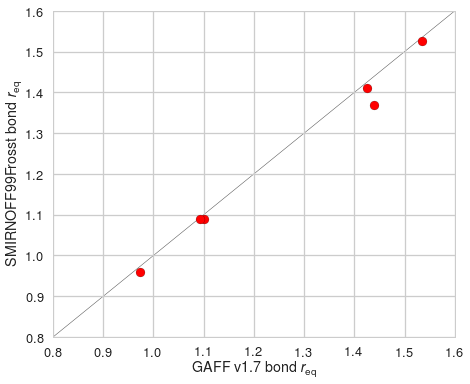

In [93]:
scatter(df, "req_bgbg_tip3p", "req_smirnoff", r"GAFF v1.7 bond $r_\text{eq}$", r"SMIRNOFF99Frosst bond $r_\text{eq}$", 0.8, 1.6, "r", 
        "SMIRNOFF99Frosst-vs-GAFF-v1.7-bond-req.pdf")


In [9]:
def find_dihedrals(structure):
    df = pd.DataFrame()
    for atom in structure.atoms:
        for dihedral in atom.dihedrals:
            df = df.append(
                pd.DataFrame(
                    {
                        "atom1": dihedral.atom1.name,
                        "atom2": dihedral.atom2.name,
                        "atom3": dihedral.atom3.name,
                        "atom4": dihedral.atom4.name,
                        "phi_k": dihedral.type.phi_k,
                        "per": dihedral.type.per,
                        "phase": dihedral.type.phase,
                    },
                    index=[0],
                ),
                ignore_index=True,
            )
    return df


In [12]:
smirnoff_dihedrals = find_dihedrals(smirnoff)
bgbg_tip3p_dihedrals = find_dihedrals(bgbg_tip3p)
bg2bg2_tip3p_dihedrals = find_dihedrals(bg2bg2_tip3p)

In [13]:
df = smirnoff_dihedrals.merge(bgbg_tip3p_dihedrals, on=["atom1", "atom2", "atom3", "atom4", "per"], 
                              suffixes=("_smirnoff", "_bgbg_tip3p"))

In [14]:
df.head()

,atom1,atom2,atom3,atom4,per,phase_smirnoff,phi_k_smirnoff,phase_bgbg_tip3p,phi_k_bgbg_tip3p
0,O1,C1,C2,O2,3,0.0,0.144,0.0,0.144
1,O1,C1,C2,O2,3,0.0,0.144,0.0,0.144
2,O1,C1,C2,O2,3,0.0,0.144,0.0,0.144
3,O1,C1,C2,O2,3,0.0,0.144,0.0,0.144
4,O1,C1,C2,O2,3,0.0,0.144,0.0,0.144


In [15]:
df.drop_duplicates(inplace=True, subset=["phase_smirnoff", 
                                         "phi_k_smirnoff",
                                         "phase_bgbg_tip3p",
                                         "phi_k_bgbg_tip3p"])

In [16]:
df.head()

,atom1,atom2,atom3,atom4,per,phase_smirnoff,phi_k_smirnoff,phase_bgbg_tip3p,phi_k_bgbg_tip3p
0,O1,C1,C2,O2,3,0.0,0.144,0.000000,0.144000
576,O1,C1,C2,O2,2,0.0,1.175,0.000000,1.175000
1152,O1,C1,C2,C3,3,0.0,0.156,0.000000,0.155556
2320,C1,C2,C3,C4,3,0.0,0.180,0.000000,0.180000
2896,C1,C2,C3,C4,2,180.0,0.250,180.000077,0.250000


In [17]:
df[["phi_k_smirnoff", "phi_k_bgbg_tip3p"]].max()

phi_k_smirnoff      1.35
phi_k_bgbg_tip3p    1.35
dtype: float64

In [18]:
df[["phi_k_smirnoff", "phi_k_bgbg_tip3p"]].min()

phi_k_smirnoff      0.0
phi_k_bgbg_tip3p    0.0
dtype: float64

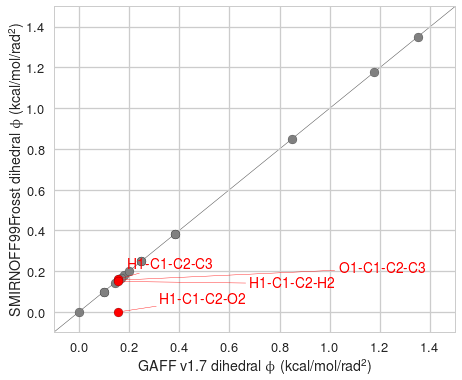

In [19]:
scatter(df, "phi_k_bgbg_tip3p", "phi_k_smirnoff", r"GAFF v1.7 dihedral $\phi$ (kcal/mol/rad$^2$)", r"SMIRNOFF99Frosst dihedral $\phi$ (kcal/mol/rad$^2$)", 
        -0.1, 1.5, "r", 
        "SMIRNOFF99Frosst-vs-GAFF-v1.7-dih-phi.pdf",
       adjust=True)


In [21]:
df = bgbg_tip3p_dihedrals.merge(bg2bg2_tip3p_dihedrals, on=["atom1", "atom2", "atom3", "atom4", "per"], 
                              suffixes=("_bgbg_tip3p", "_bg2bg2_tip3p"))

df.drop_duplicates(inplace=True, subset=["phase_bgbg_tip3p", 
                                         "phi_k_bgbg_tip3p",
                                         "phase_bg2bg2_tip3p",
                                         "phi_k_bg2bg2_tip3p"])

print(f'Max: {df[["phi_k_bgbg_tip3p", "phi_k_bg2bg2_tip3p"]].max()}')
print(f'Min: {df[["phi_k_bgbg_tip3p", "phi_k_bg2bg2_tip3p"]].min()}')

Max: phi_k_bgbg_tip3p      1.35
phi_k_bg2bg2_tip3p    1.24
dtype: float64
Min: phi_k_bgbg_tip3p      0.0
phi_k_bg2bg2_tip3p    0.0
dtype: float64


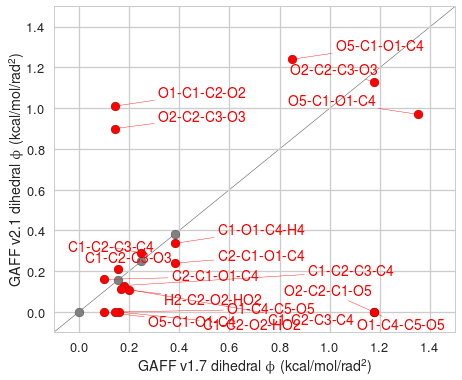

In [23]:
scatter(df, "phi_k_bgbg_tip3p", "phi_k_bg2bg2_tip3p", r"GAFF v1.7 dihedral $\phi$ (kcal/mol/rad$^2$)", r"GAFF v2.1 dihedral $\phi$ (kcal/mol/rad$^2$)", 
        -0.1, 1.5, "r", 
        "GAFF-v2.1-vs-GAFF-v1.7-dih-phi.pdf",
       adjust=True)
